In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

###Constants

$C_0 = 0.05$</br>
$m_l = -81.1$</br>
$m_s = -478$</br>
$c_p = 820$</br>
$ρ = 7000$</br>
$L_f = 276000$</br>
$T_f = 1538$</br>
$T_∞ = 1540$</br>
$T_0 = 1510$</br>
$k_0 = 0.17$</br>
$Le = 300$</br>

$Ste = c_p(T_∞-T_0)/L_f$</br>
$θ_f = (T_f-T_0)/(T_∞-T_0)$

###Conditions

Domain $\epsilon \in [0,ϵ^*]$</br>
$C_s = k_0C_l^*$</br>
PDE1: $\frac{∂\theta_s}{∂\tau} = \frac{∂^2\theta_s}{∂\epsilon^2}$</br>
Domain $\epsilon \in [ϵ^*,1]$</br>
PDE2: $\frac{∂\theta_l}{∂\tau} = \frac{∂^2\theta_l}{∂\epsilon^2}$</br>
PDE3: $\frac{∂C_l}{∂\tau} = \frac{1}{Le}\frac{∂^2C_l}{∂\epsilon^2}$</br>
Interface ($ϵ=ϵ^*$)</br>
PDE4: $\frac{1}{Ste}\frac{∂\epsilon^*}{∂\tau} = \frac{∂\theta_s}{∂\epsilon}-\frac{∂\theta_l}{∂\epsilon}$</br>
PDE5: $\frac{-1}{Le}\frac{∂C_l}{∂ϵ}=C_l^*(1-k_0)\frac{dϵ^*}{dτ}$</br>

5 PDEs with 5 Variables [$θ_s(x,t)$, $θ_l(x,t)$, $C_s(x,t)$, $C_l(x,t)$, $ϵ^*(t)$]</br>
Model the 5 variables using 5 neural networks and optimise the NN parameters</br>

Initial ($\tau = 0$)</br>
$θ_l=1$ ; $C_l=C_0$ ; $ϵ^*=0$</br>
Interface ($ϵ=ϵ^*$)</br>
$θ_s=θ_l=θ^*$</br>
$C_l^* = (T_0-T_∞)(θ_f-θ^*)/m_l$</br>
Left BC ($ϵ=0$)</br>
$θ_s=0$

##Code

In [ ]:
import tensorflow as tf
import math as m

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE) # sets the default float type as 32-bit float

a = tf.constant(1., dtype=DTYPE)
C0, Le, cp, Ti, T0, Tf, Lf, ml, k0, phi = 0.05*a, 300*a, 820*a, 1540*a, 1510*a, 1538*a, 276000*a, -81.1*a, 0.17*a, 0.1159*a
Ste = cp*(Ti-T0)/Lf
uf = (Tf-T0)/(Ti-T0)
pie = tf.constant(m.pi, dtype=DTYPE)
ustar = tf.math.erf(phi)*(1+(tf.math.erfc(phi)*tf.math.exp(phi**2)*phi*(pie**0.5)/Ste)) # actual temp coeff at interface

In [ ]:
def C_(u_):
  return (T0-Ti)*(uf-u_)/ml # concentration of liquid at interface (Cl*) given interface temp

###Evaluating PDEs

In [ ]:
def f1(u1_t, u1_xx): # calculates PDE1 value given u1's derivatives
  return u1_t - u1_xx

def f2(u2_t, u2_xx): # calculates PDE2 value given u2's derivatives
  return u2_t - u2_xx

def f3(c_t, c_xx): # calculates PDE3 value given c's derivatives
  return c_t - (c_xx/Le)

def f4(s_t, u1_x, u2_x): # calculates PDE4 value
  return (s_t/Ste) - u1_x + u2_x

def f5(c_x, cstar, s_t): # calculates PDE5 value
  return (cstar*(1-k0)*s_t)+(c_x/Le)

###Analytical Solutions

In [ ]:
def u1_anal(t,x): # calculates u1 value from its analytical solution
  return ustar*tf.math.erf(x/(2*(t**0.5)))/tf.math.erf(phi)

def u2_anal(t,x): # calculates u2 value from its analytical solution
  return 1-((1-ustar)*tf.math.erfc(x/(2*(t**0.5)))/tf.math.erfc(phi))

c1_anal = k0*C_(ustar) # analytical value of Cs

def c2_anal(t,x): # calculates c2 value from its analytical solution
  return C0 + ((C_(ustar)-C0)*tf.math.erfc((x*(Le**0.5))/(2*(t**0.5)))/tf.math.erfc(phi*(Le**0.5)))

def s_anal(t): # calculates s value from its analytical solution
  return 2*phi*(t**0.5)

def u_anal(t,x): # analytical value of u given x and t
  return tf.where(tf.math.greater(s_anal(t),x),u1_anal(t,x),u2_anal(t,x))

def c_anal(t,x): # analytical value of c given x and t
  return tf.where(tf.math.greater(s_anal(t),x),c1_anal,c2_anal(t,x))

###Training Data

In [ ]:
Nm1, Nm2 = 900, 50 # no of measurement points

tmin, tmax = tf.constant(0.), tf.constant(10.) # lower and upper limit on time
xmin, xmax = tf.constant(0.), tf.constant(1.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

tm1 = tf.random.uniform((Nm1,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
tm2 = tf.random.uniform((Nm2,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
im = tf.zeros(shape=(Nm2,1), dtype=DTYPE)
tm = tf.concat([tm1,tm2,im],axis=0)
xm1 = tf.random.uniform((Nm1,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
sm = s_anal(tm2)
xm2 = tf.random.uniform((Nm2,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
xm = tf.concat([xm1,sm,xm2],axis=0)
meas = tf.concat([tm, xm], axis=1) # Measurement Data Points
um = u_anal(tm,xm) # Analytical value of u at these points
cm = c_anal(tm,xm) # Analytical value of c at these points
sm2 = s_anal(tm)

In [ ]:
Nm = 200 # no of measurement points

tmin, tmax = tf.constant(0.), tf.constant(10.) # lower and upper limit on time
xmin, xmax = tf.constant(0.), tf.constant(1.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

tm = tf.random.uniform((Nm,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xm = tf.random.uniform((Nm,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
meas = tf.concat([tm, xm], axis=1) # Measurement Data Points
um = u_anal(tm,xm) # Analytical value of u at these points
cm = c_anal(tm,xm) # Analytical value of c at these points

###Optional Data

In [ ]:
Ni, Nb, Nc = 50, 50, 10000 # no of initial, boundary and collocation points

ti = tf.ones((Ni,1))*tmin # tmin repeated Ni times
xi = tf.random.uniform((Ni,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
init = tf.concat([ti, xi], axis=1) # Initial Data Points

tb = tf.random.uniform((Nb,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xb = tf.ones((Nb,1))*xmin # xmin repeated Nb times
bound = tf.concat([tb, xb], axis=1) # Boundary Data Points

tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
coll = tf.concat([tc, xc], axis=1) # Collocation Data Points

###Modelling Variables

In [ ]:
def u1_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for Ts
  return model

def u2_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for Tl
  return model

def c1_model(n_hidden = 1, n_neurons = 5):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for Cs
  return model

def c2_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for Cl
  return model

def s_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(1)) # Input Layer for t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for s
  return model

###Compute gradients to return PDE values

In [ ]:
def get_f(u1model, u2model, smodel, c2model, cps): # calculate f values given models and collocation points
  with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
    t, x = cps[:, 0:1], cps[:, 1:2] # extract t and x data each having shape (Nc,1)
    tape.watch(t)
    tape.watch(x)
    u1 = u1model(tf.concat([t, x], axis=1)) # u1 as a function of t and x
    u2 = u2model(tf.concat([t, x], axis=1)) # u2 as a function of t and x
    c2 = c2model(tf.concat([t, x], axis=1)) # c2 as a function of t and x
    s = smodel(t)
    tape.watch(s)
    u1b = u1model(tf.concat([t, s], axis=1))
    u2b = u2model(tf.concat([t, s], axis=1))
    cb = c2model(tf.concat([t, s], axis=1))
    # defined within context to compute 2nd derivatives
    u1_x = tape.gradient(u1, x)
    u2_x = tape.gradient(u2, x)
    c_x = tape.gradient(c2, x)
  u1b_x = tape.gradient(u1b, s)
  u2b_x = tape.gradient(u2b, s)
  cb_x = tape.gradient(cb, s)
  s_t = tape.gradient(s, t)
  c_t = tape.gradient(c2, t)
  u1_t = tape.gradient(u1, t)
  u2_t = tape.gradient(u2, t)
  u1_xx = tape.gradient(u1_x, x)
  u2_xx = tape.gradient(u2_x, x)
  c_xx = tape.gradient(c_x, x)
  del tape
  return f1(u1_t, u1_xx), f2(u2_t, u2_xx), f3(c_t, c_xx), f4(s_t, u1b_x, u2b_x), f5(cb_x, cb, s_t)

###Calculating loss

In [ ]:
init = tf.constant(0,shape=(1,1),dtype=DTYPE)

In [ ]:
def loss_fxn(u1model, u2model, smodel, c1model, c2model, mea, um, cm, xc, times): # compute loss given model and data

    pu1m = u1model(mea) # Solid Temperature prediction on measurement data
    pu2m = u2model(mea) # Liquid Temperature prediction on measurement data
    pc1m = c1model(mea) # Solid Concentration prediction on measurement data
    pc2m = c2model(mea) # Liquid Concentration prediction on measurement data
    psm = smodel(mea[:, 0:1]) # Interface prediction on measurement data
    pum = tf.where(tf.math.greater(psm,mea[:,1:2]), pu1m, pu2m)
    pcm = tf.where(tf.math.greater(psm,mea[:,1:2]), pc1m, pc2m)
    Lm1 = tf.reduce_mean(tf.square(um - pum))
    Lm2 = tf.reduce_mean(tf.square(cm - pcm))
    Lm3 = tf.reduce_mean(tf.square(sm2 - psm))
    Lm = (Lm1 + Lm2 + Lm3)*25.6

    ti = tf.zeros(shape=xc.shape, dtype=DTYPE)
    init2 = tf.concat([ti, xc], axis=1)
    pu2i = u2model(init2) # predicted initial temp of liquid
    pc2i = c2model(init2) # predicted initial conc of liquid
    Li1 = tf.squeeze(tf.square(smodel(init)))
    Li2 = tf.reduce_mean(tf.square(pc2i-C0))
    Li3 = tf.reduce_mean(tf.square(pu2i-a))
    Li = Li1*25600 + Li2*100 + Li3*100

    tot_loss = Lm + Li
    sum_loss = tf.zeros(shape=(), dtype=DTYPE)
    error = Lm1+Lm2+Lm3+Li1+Li2+Li3
    #weights = []

    for t in times:

      ts = tf.reshape(t,(1,1))
      psb = smodel(ts) # Predicted Interface position
      pu1b = u1model(tf.concat([ts, psb], axis=1)) # Solid Interface Temperature prediction
      pu2b = u2model(tf.concat([ts, psb], axis=1)) # Liquid Interface Temperature prediction
      pcb = c2model(tf.concat([ts, psb], axis=1)) # Liquid Interface Concentration prediction
      pu0b = u1model(tf.concat([ts, init], axis=1)) # Left Boundary Temperature prediction
      Lb1 = tf.reduce_mean(tf.square(pu0b))
      Lb2 = tf.reduce_mean(tf.square(pu1b-pu2b))
      Lb3 = tf.reduce_mean(tf.square(pcb-C_(pu1b)))
      Lb = (Lb1 + Lb2 + Lb3)*256

      tc = tf.ones_like(xc,dtype=DTYPE)*t
      coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
      f_1, f_2, f_3, f_4, f_5 = get_f(u1model, u2model, smodel, c2model, coll) # calculate f values given models and collocation data
      Lc1 = tf.reduce_mean(tf.square(f_1))
      Lc2 = tf.reduce_mean(tf.square(f_2))
      Lc3 = tf.reduce_mean(tf.square(f_3))
      Lc4 = tf.reduce_mean(tf.square(f_4))
      Lc5 = tf.reduce_mean(tf.square(f_5))
      pc1 = c1model(coll)
      Ls = tf.reduce_mean(tf.square(pc1-(k0*pcb))) # relation bwn Cs and Cl*
      Lc = Lc1 + Lc2 + Lc3 + Lc4 + Lc5 + Ls

      w = tf.math.exp(-sum_loss)
      #weights.append(w)
      tot_loss += w*(Lc+Lb)/Nt
      sum_loss += (Lc+Lb)
      error += (Lb1+Lb2+Lb3+Lc)/Nt

    return tot_loss, error#, weights

###Computing Loss Gradients

In [ ]:
def L_and_grad_Lw(u1model, u2model, smodel, c1model, c2model, meas, um, cm, xc, times): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(u1model.trainable_variables) # keep track of operations on u1model training parameters
    tape.watch(u2model.trainable_variables) # keep track of operations on u2model training parameters
    tape.watch(smodel.trainable_variables) # keep track of operations on smodel training parameters
    tape.watch(c1model.trainable_variables) # keep track of operations on c1model training parameters
    tape.watch(c2model.trainable_variables) # keep track of operations on c2model training parameters
    loss, error = loss_fxn(u1model, u2model, smodel, c1model, c2model, meas, um, cm, xc, times) # loss as a function of model (& hence weights)
  gu1 = tape.gradient(loss, u1model.trainable_variables)
  gu2 = tape.gradient(loss, u2model.trainable_variables)
  gs = tape.gradient(loss, smodel.trainable_variables)
  gc1 = tape.gradient(loss, c1model.trainable_variables)
  gc2 = tape.gradient(loss, c2model.trainable_variables)
  del tape
  return loss, gu1, gu2, gs, gc1, gc2, error

In [ ]:
Nt, Nx = 100, 256 # No of t and x points sampled
u1model = u1_model() # initialise the Solid Temp NN model
u2model = u2_model() # initialise the Liquid Temp NN model
smodel = s_model() # initialise the Intf NN model
c1model = c1_model() # initialise the Solid Conc NN model
c2model = c2_model() # initialise the Liquid Conc NN model
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([250,1000],[1e-2,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005) # Adam Optimiser

In [ ]:
@tf.function

def train_step(xc, times):

  # compute loss and its gradient wrt model parameters
  loss, gu1, gu2, gs, gc1, gc2, error = L_and_grad_Lw(u1model, u2model, smodel, c1model, c2model, meas, um, cm, xc, times)

  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gu1, u1model.trainable_variables))
  optim.apply_gradients(zip(gu2, u2model.trainable_variables))
  optim.apply_gradients(zip(gs, smodel.trainable_variables))
  optim.apply_gradients(zip(gc1, c1model.trainable_variables))
  optim.apply_gradients(zip(gc2, c2model.trainable_variables))

  return loss, error

In [ ]:
# LR = 0.0005
from time import time
N = 500 # no of epochs or training iterations
losses = []
errors = []
t0 = time()
tf.random.set_seed(0)

for i in range(1,N+1):
    xc = tf.random.uniform((Nx,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
    times = tf.random.uniform((Nt,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
    loss, error = train_step(xc, times)
    losses.append(loss.numpy())
    errors.append(error.numpy())
    if i%10==0:
        print('Epoch = '+str(i)+' --> Loss = '+str(loss.numpy())+'  and Error = '+str(error.numpy()))

print('Computation Time = {} minutes'.format((time()-t0)/60))

Epoch = 10 --> Loss = 82.3692  and Error = 2.5506392
Epoch = 20 --> Loss = 16.783424  and Error = 2.55965
Epoch = 30 --> Loss = 8.391466  and Error = 3.2214391
Epoch = 40 --> Loss = 6.7743406  and Error = 1.874601
Epoch = 50 --> Loss = 3.9799871  and Error = 2.0917683
Epoch = 60 --> Loss = 3.103047  and Error = 1.5328583
Epoch = 70 --> Loss = 1.9448416  and Error = 1.6046805
Epoch = 80 --> Loss = 1.4376752  and Error = 1.5277137
Epoch = 90 --> Loss = 1.408819  and Error = 1.0548728
Epoch = 100 --> Loss = 0.6517774  and Error = 0.8685169
Epoch = 110 --> Loss = 0.517915  and Error = 0.53522766
Epoch = 120 --> Loss = 0.44212982  and Error = 0.44352487
Epoch = 130 --> Loss = 0.40174574  and Error = 0.3688814
Epoch = 140 --> Loss = 0.4672315  and Error = 0.6767012
Epoch = 150 --> Loss = 0.3203677  and Error = 0.42641953
Epoch = 160 --> Loss = 0.31538495  and Error = 0.41757804
Epoch = 170 --> Loss = 0.29272088  and Error = 0.38950258
Epoch = 180 --> Loss = 0.26884073  and Error = 0.5043813


Text(0, 0.5, 'Loss')

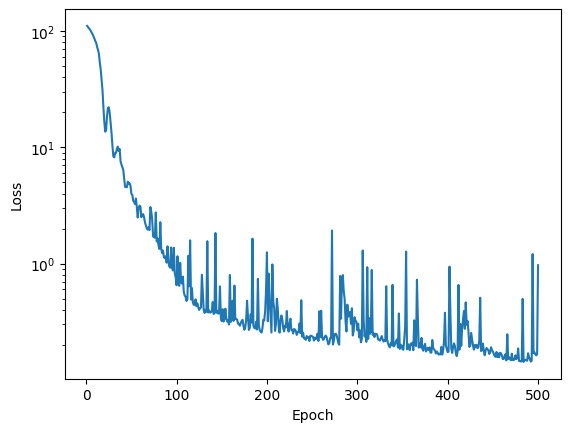

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,len(losses)+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Error')

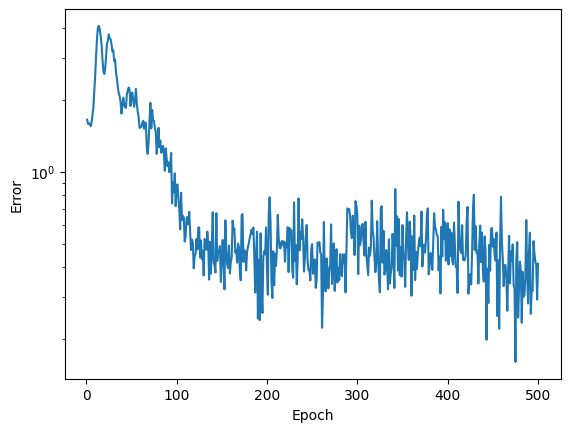

In [ ]:
plt.yscale('log')
plt.plot(epochs, errors)
plt.xlabel('Epoch')
plt.ylabel('Error')

Text(0, 0.5, 'u (Temperature)')

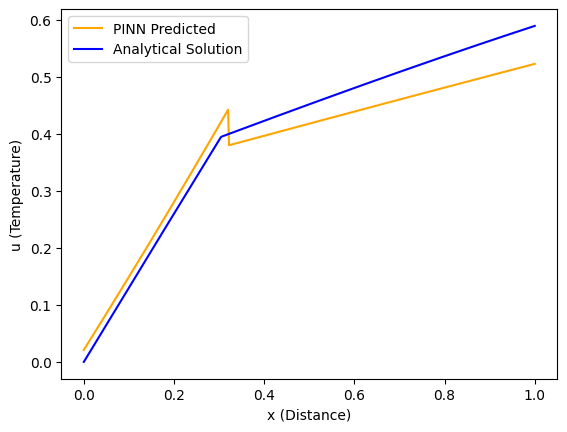

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
u1p = u1model(tf.concat([T, X], axis=1))
u2p = u2model(tf.concat([T, X], axis=1))
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

In [ ]:
spred.numpy()[0][0], s_anal(T).numpy()[0][0]

(0.32094976, 0.3044444)

Text(0, 0.5, 'c (Concentration)')

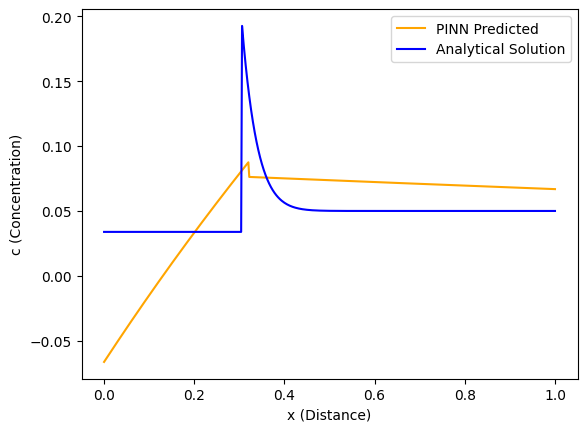

In [ ]:
c1p = c1model(tf.concat([T, X], axis=1))
c2p = c2model(tf.concat([T, X], axis=1))
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

In [ ]:
# LR = 0.0001
from time import time
N = 500 # no of epochs or training iterations for each e
losses = []
t0 = time()
tf.random.set_seed(0)
#epsilons = [0.01,0.1,1,10,100]

#for e in epsilons:
    #print('Looping for epsilon = '+str(e)+' ...')
for i in range(1,N+1):
    xc = tf.random.uniform((Nx,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
    times = tf.random.uniform((Nt,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
    loss, weights = train_step(xc, times)
    losses.append(loss.numpy())
    if i%10==0:
        print('Epoch = '+str(i)+' --> Loss = '+str(loss.numpy()))

print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

Epoch = 10 --> Loss = 111.91892
Epoch = 20 --> Loss = 103.62278
Epoch = 30 --> Loss = 94.007706
Epoch = 40 --> Loss = 80.922844
Epoch = 50 --> Loss = 61.83904
Epoch = 60 --> Loss = 38.307865
Epoch = 70 --> Loss = 18.275473
Epoch = 80 --> Loss = 12.371324
Epoch = 90 --> Loss = 11.1733885
Epoch = 100 --> Loss = 8.757711
Epoch = 110 --> Loss = 8.013213
Epoch = 120 --> Loss = 6.5006742
Epoch = 130 --> Loss = 6.7456737
Epoch = 140 --> Loss = 6.270397
Epoch = 150 --> Loss = 5.812969
Epoch = 160 --> Loss = 5.082766
Epoch = 170 --> Loss = 5.0386686
Epoch = 180 --> Loss = 4.32488
Epoch = 190 --> Loss = 4.6760454
Epoch = 200 --> Loss = 4.4144173
Epoch = 210 --> Loss = 3.7704635
Epoch = 220 --> Loss = 3.5431497
Epoch = 230 --> Loss = 3.2233624
Epoch = 240 --> Loss = 3.1036344
Epoch = 250 --> Loss = 2.8300805
Epoch = 260 --> Loss = 2.8481045
Epoch = 270 --> Loss = 2.5789547
Epoch = 280 --> Loss = 2.2988586
Epoch = 290 --> Loss = 2.2628338
Epoch = 300 --> Loss = 2.1761727
Epoch = 310 --> Loss = 2.1

In [ ]:
# LR = 0.001
from time import time
N = 500 # no of epochs or training iterations for each e
losses = []
t0 = time()
tf.random.set_seed(0)
#epsilons = [0.01,0.1,1,10,100]

#for e in epsilons:
    #print('Looping for epsilon = '+str(e)+' ...')
for i in range(1,N+1):
    xc = tf.random.uniform((Nx,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
    times = tf.random.uniform((Nt,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
    loss, weights = train_step(xc, times)
    losses.append(loss.numpy())
    if i%10==0:
        print('Epoch = '+str(i)+' --> Loss = '+str(loss.numpy()))

print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

Epoch = 10 --> Loss = 103.29921
Epoch = 20 --> Loss = 156.358
Epoch = 30 --> Loss = 82.53522
Epoch = 40 --> Loss = 6.8103666
Epoch = 50 --> Loss = 4.680705
Epoch = 60 --> Loss = 4.086816
Epoch = 70 --> Loss = 2.927535
Epoch = 80 --> Loss = 2.503396
Epoch = 90 --> Loss = 1.8394053
Epoch = 100 --> Loss = 1.5390468
Epoch = 110 --> Loss = 9.423834
Epoch = 120 --> Loss = 1.4886949
Epoch = 130 --> Loss = 50.226704
Epoch = 140 --> Loss = 36.60953
Epoch = 150 --> Loss = 28.39756
Epoch = 160 --> Loss = 15.854148
Epoch = 170 --> Loss = 6.69761
Epoch = 180 --> Loss = 5.832824
Epoch = 190 --> Loss = 3.6215158
Epoch = 200 --> Loss = 2.5791883
Epoch = 210 --> Loss = 1.4423383
Epoch = 220 --> Loss = 0.6908425
Epoch = 230 --> Loss = 0.88954085
Epoch = 240 --> Loss = 0.81909114
Epoch = 250 --> Loss = 0.73261154
Epoch = 260 --> Loss = 0.6327525
Epoch = 270 --> Loss = 0.63417244
Epoch = 280 --> Loss = 0.732077
Epoch = 290 --> Loss = 0.71151614
Epoch = 300 --> Loss = 0.66359484
Epoch = 310 --> Loss = 0.63

In [ ]:
# LR = 0.001
from time import time
N = 100 # no of epochs or training iterations for each e
delta = 0.99
losses = []
t0 = time()
tf.random.set_seed(0)
epsilons = [0.01,0.1,1,10,100]

for e in epsilons:
    print('Looping for epsilon = '+str(e)+' ...')
    for i in range(1,N+1):
        xc = tf.random.uniform((Nx,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
        times = tf.random.uniform((Nt,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
        loss, weights = train_step(xc, times, e)
        losses.append(loss.numpy())
        if i%10==0:
            print('   Epoch = '+str(i)+' --> Loss = '+str(loss.numpy()))
        if tf.math.reduce_min(weights).numpy()>delta:
            break

print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

Looping for epsilon = 0.01 ...
   Epoch = 10 --> Loss = 68.52455
   Epoch = 20 --> Loss = 650.2027
   Epoch = 30 --> Loss = 123.48941
   Epoch = 40 --> Loss = 5.7109017
   Epoch = 50 --> Loss = 4.598176
   Epoch = 60 --> Loss = 4.201915
   Epoch = 70 --> Loss = 3.748523
   Epoch = 80 --> Loss = 3.3603055
   Epoch = 90 --> Loss = 2.9420464
   Epoch = 100 --> Loss = 2.4981558
Looping for epsilon = 0.1 ...
   Epoch = 10 --> Loss = 102.61027
   Epoch = 20 --> Loss = 86.46077
   Epoch = 30 --> Loss = 124.450066
   Epoch = 40 --> Loss = 71.788
   Epoch = 50 --> Loss = 66.52281
   Epoch = 60 --> Loss = 68.97779
   Epoch = 70 --> Loss = 57.80754
   Epoch = 80 --> Loss = 59.598972
   Epoch = 90 --> Loss = 52.993473
   Epoch = 100 --> Loss = 51.923447
Looping for epsilon = 1 ...
   Epoch = 10 --> Loss = 46.191853
   Epoch = 20 --> Loss = 40.99925
   Epoch = 30 --> Loss = 38.63402
   Epoch = 40 --> Loss = 39.656483
   Epoch = 50 --> Loss = 35.9275
   Epoch = 60 --> Loss = 3.0334392
   Epoch = 70 

In [ ]:
# LR = 0.001
from time import time
N = 200 # no of epochs or training iterations
losses = []
t0 = time()

for i in range(1,N+1):
    xc = tf.random.uniform((Nx,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
    times = tf.random.uniform((Nt,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
    loss, weights = train_step(xc, times)
    losses.append(loss.numpy())
    if i%10==0:
        print('Epoch = '+str(i)+' --> Loss = '+str(loss.numpy()))

print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

Epoch = 10 --> Loss = 70.026855
Epoch = 20 --> Loss = 27.781273
Epoch = 30 --> Loss = 6.5605187
Epoch = 40 --> Loss = 4.538131
Epoch = 50 --> Loss = 3.454031
Epoch = 60 --> Loss = 2.8539188
Epoch = 70 --> Loss = 3.4110289
Epoch = 80 --> Loss = 2.2716053
Epoch = 90 --> Loss = 1.9412854
Epoch = 100 --> Loss = 1.8142481
Epoch = 110 --> Loss = 1.3536463
Epoch = 120 --> Loss = 1.4183996
Epoch = 130 --> Loss = 1.3115295
Epoch = 140 --> Loss = 1.1590331
Epoch = 150 --> Loss = 1.174088
Epoch = 160 --> Loss = 0.9888044
Epoch = 170 --> Loss = 0.88855845
Epoch = 180 --> Loss = 0.8246505
Epoch = 190 --> Loss = 0.77416104
Epoch = 200 --> Loss = 0.7264333
Final Loss = 0.7264333
Computation Time = 531.5055154124896 minutes


No oscillations yet, run for more epochs

In [ ]:
# LR = 0.01
from time import time
N = 200 # no of epochs or training iterations
losses = []
t0 = time()

for i in range(1,N+1):
    xc = tf.random.uniform((Nx,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
    times = tf.random.uniform((Nt,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
    loss, weights = train_step(xc, times)
    losses.append(loss.numpy())
    if i%10==0:
        print('Epoch = '+str(i)+' --> Loss = '+str(loss.numpy()))

print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

Epoch = 10 --> Loss = 255.72337
Epoch = 20 --> Loss = 8.550247
Epoch = 30 --> Loss = 181.01701
Epoch = 40 --> Loss = 2.0811286
Epoch = 50 --> Loss = 1.4292207
Epoch = 60 --> Loss = 0.934685
Epoch = 70 --> Loss = 62.510414
Epoch = 80 --> Loss = 68.598526
Epoch = 90 --> Loss = 51.348022
Epoch = 100 --> Loss = 37.841755
Epoch = 110 --> Loss = 32.707832
Epoch = 120 --> Loss = 29.555328
Epoch = 130 --> Loss = 18.953934
Epoch = 140 --> Loss = 13.121825
Epoch = 150 --> Loss = 9.012226
Epoch = 160 --> Loss = 9.704497
Epoch = 170 --> Loss = 8.704591
Epoch = 180 --> Loss = 3.0685081
Epoch = 190 --> Loss = 1.2076814
Epoch = 200 --> Loss = 46.616222
Final Loss = 46.616222
Computation Time = 366.3992019891739 minutes
